<a href="https://colab.research.google.com/github/jesusalzate/TGSS_Loss_Multiple_Labelers/blob/main/Custom_Loss_Function_Prostate158.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jul 10 07:28:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading Data Prostate 158

In [ ]:
!wget https://zenodo.org/records/6481141/files/prostate158_train.zip?download=1 -O prostate158_train.zip
!unzip prostate158_train.zip
!rm prostate158_train.zip

--2024-07-10 07:28:53--  https://zenodo.org/records/6481141/files/prostate158_train.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2779077552 (2.6G) [application/octet-stream]
Saving to: ‘prostate158_train.zip’

prostate158_train.z 100%[===================>]   2.59G  22.0MB/s    in 2m 7s   

2024-07-10 07:31:00 (20.8 MB/s) - ‘prostate158_train.zip’ saved [2779077552/2779077552]

Archive:  prostate158_train.zip
   creating: prostate158_train/
   creating: prostate158_train/train/
  inflating: prostate158_train/train.csv  
   creating: prostate158_train/train/020/
 extracting: prostate158_train/train/020/adc.nii.gz  
  inflating: prostate158_train/train/020/adc_tumor_reader1.nii.gz  
  inflating: prostate158_train/train/020/adc_tumor_reader2.nii.gz  
 extracting: prostate158_train/train/020/dwi.nii.gz  
  

In [ ]:
# Install Dependencies
!pip install monai[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.0/359.0 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━

## Importing Libraries

In [ ]:
import os
import argparse

from tqdm import tqdm
import json

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    CropForegroundd,
    RandAffined,
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureChannelFirstd,
    SpatialPadd,
    ToTensord,
    RandCropByPosNegLabeld,
    RandGaussianNoised,
    RandAdjustContrastd,
    RandFlipd,
    RandGaussianSmoothd,
    RandRotated,
    AsDiscreted,
    ResampleToMatchd,
    ConcatItemsd,
    ConcatItemsd,
    ScaleIntensityd
)
import monai
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    CacheDataset,
    Dataset,
    decollate_batch,
    set_track_meta,
)
from monai.visualize import matshow3d
import matplotlib.pyplot as plt
import pandas as pd


import torch
import numpy as np
from time import sleep

from datetime import datetime

## Auxiliar Functions

In [ ]:
def custom_print(*args, **kwargs):
    # Get the current datetime
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    # Construct the message with the datetime
    formatted_message = f"{current_time} - {' '.join(map(str, args))}"
    # Use the built-in print function to display the message
    print(formatted_message, **kwargs)

In [ ]:
# Train Function
def train(
    model,
    data_in,
    loss,
    optim,
    max_epochs,
    model_dir,
    device,
    name,
    test_interval=1,
    start_epoch=0,
):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    save_metric_test_per_class = []
    save_iou_test_per_class = []
    train_loader, test_loader = data_in

    data_classes = [
        "csPCa"
    ]

    for epoch in range(start_epoch, max_epochs):
        print("-" * 50)
        custom_print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_data in tepoch:
                current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                tepoch.set_description(f"{current_time} - Epoch {epoch+1}")
                train_step += 1

                volume = batch_data["image"]
                label = batch_data["label"]
                # print(volume.shape)
                # print(label.shape)
                volume, labels = (volume.to(device), label.to(device))

                optim.zero_grad()
                outputs = model(volume)
                train_loss = loss(outputs, labels)

                train_loss.backward()
                optim.step()

                train_epoch_loss += train_loss.item()
                labels_list = decollate_batch(labels)
                labels_convert = [
                    post_label(label_tensor) for label_tensor in labels_list
                ]

                output_list = decollate_batch(outputs)
                output_convert = [
                    post_pred(output_tensor) for output_tensor in output_list
                ]

                dice_metric(y_pred=output_convert, y=labels_convert)
                iou_metric(y_pred=output_convert, y=labels_convert)

                tepoch.set_postfix(
                    loss=train_loss.item(),
                    dice_score=dice_metric.aggregate(reduction="mean").item(),
                )
                sleep(0.01)

            torch.save(
                {
                    "epoch": epoch + 1,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                },
                os.path.join(model_dir, name + "_last_checkpoint.pth"),
            )

            print("-" * 20)

            train_epoch_loss /= train_step
            print(f"Epoch_loss: {train_epoch_loss:.4f}")
            save_loss_train.append(train_epoch_loss)
            np.save(os.path.join(model_dir, name + "_loss_train.npy"), save_loss_train)

            epoch_metric_train = dice_metric.aggregate(reduction="mean").item()
            dice_metric.reset()

            print(f"Epoch_metric: {epoch_metric_train:.4f}")

            iou_metric_train = iou_metric.aggregate(reduction="mean").item()
            iou_metric.reset()

            print(f"IoU_metric: {iou_metric_train:.4f}")

            save_metric_train.append(epoch_metric_train)
            np.save(
                os.path.join(model_dir, name + "_metric_train.npy"), save_metric_train
            )

            if (epoch + 1) % test_interval == 0:

                model.eval()
                with torch.no_grad():
                    test_epoch_loss = 0
                    test_metric = 0
                    epoch_metric_test = 0
                    test_step = 0

                    for test_data in tqdm(test_loader):

                        test_step += 1

                        test_volume = test_data["image"]
                        test_label = test_data["label"]

                        test_volume, test_label = (
                            test_volume.to(device),
                            test_label.to(device),
                        )

                        test_outputs = sliding_window_inference(
                            test_volume,patch_size, 2, model, overlap=0.5
                        )

                        test_loss = loss(test_outputs, test_label)
                        test_epoch_loss += test_loss.item()

                        labels_list = decollate_batch(test_label)
                        labels_convert = [
                            post_label(label_tensor) for label_tensor in labels_list
                        ]

                        output_list = decollate_batch(test_outputs)
                        output_convert = [
                            post_pred(output_tensor) for output_tensor in output_list
                        ]

                        dice_metric(y_pred=output_convert, y=labels_convert)
                        iou_metric(y_pred=output_convert, y=labels_convert)

                    test_epoch_loss /= test_step
                    print(f"test_loss_epoch: {test_epoch_loss:.4f}")
                    save_loss_test.append(test_epoch_loss)
                    np.save(
                        os.path.join(model_dir, name + "_loss_test.npy"), save_loss_test
                    )

                    epoch_metric_test = dice_metric.aggregate(reduction="mean").item()

                    print(f"test_dice_epoch: {epoch_metric_test:.4f}")

                    dice_scores = {
                        key: value
                        for key, value in zip(
                            data_classes,
                            dice_metric.aggregate(reduction="mean_batch").tolist(),
                        )
                    }
                    print("test_dice_epoch_per_class:")
                    for key, value in dice_scores.items():
                        print(f"\t{key}: {value}")
                    save_metric_test_per_class.append(
                        np.array(list(dice_scores.values()))
                    )
                    np.save(
                        os.path.join(model_dir, name + "_metric_test_per_class.npy"),
                        save_metric_test_per_class,
                    )

                    iou_metric_test = iou_metric.aggregate(reduction="mean").item()

                    print(f"test_iou_epoch: {iou_metric_test:.4f}")

                    iou_scores = {
                        key: value
                        for key, value in zip(
                            data_classes,
                            iou_metric.aggregate(reduction="mean_batch").tolist(),
                        )
                    }
                    print("test_iou_epoch_per_class:")
                    for key, value in iou_scores.items():
                        print(f"\t{key}: {value}")
                    save_iou_test_per_class.append(np.array(list(iou_scores.values())))
                    np.save(
                        os.path.join(model_dir, name + "_iou_test_per_class.npy"),
                        save_iou_test_per_class,
                    )

                    iou_metric.reset()
                    save_metric_test.append(epoch_metric_test)
                    np.save(
                        os.path.join(model_dir, name + "_metric_test.npy"),
                        save_metric_test,
                    )
                    dice_metric.reset()
                    if epoch_metric_test > best_metric:
                        best_metric = epoch_metric_test
                        best_metric_epoch = epoch + 1
                        torch.save(
                            {
                                "epoch": epoch + 1,
                                "state_dict": model.state_dict(),
                                "optimizer": optimizer.state_dict(),
                            },
                            os.path.join(model_dir, name + "_best_metric_model.pth"),
                        )

                    print(
                        f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test:.4f}"
                        f"\nbest mean dice: {best_metric:.4f} "
                        f"at epoch: {best_metric_epoch}"
                    )

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}"
    )

In [ ]:
path = "./prostate158_train/"
train_df = pd.read_csv(os.path.join(path, "train.csv"))
test_df = pd.read_csv(os.path.join(path, "valid.csv"))

In [ ]:
# Keep Only images with 2 annotators
train_df = train_df.dropna(subset=["adc_tumor_reader2"])
test_df = test_df.dropna(subset=["adc_tumor_reader2"])

In [ ]:
# Add path to all images
train_df["t2"] = train_df["t2"].apply(lambda x: os.path.join(path, x))
train_df["adc"] = train_df["adc"].apply(lambda x: os.path.join(path, x))
train_df["dwi"] = train_df["dwi"].apply(lambda x: os.path.join(path, x))
train_df["adc_tumor_reader1"] = train_df["adc_tumor_reader1"].apply(lambda x: os.path.join(path, x))
train_df["adc_tumor_reader2"] = train_df["adc_tumor_reader2"].apply(lambda x: os.path.join(path, x))

test_df["t2"] = test_df["t2"].apply(lambda x: os.path.join(path, x))
test_df["adc"] = test_df["adc"].apply(lambda x: os.path.join(path, x))
test_df["dwi"] = test_df["dwi"].apply(lambda x: os.path.join(path, x))
test_df["adc_tumor_reader1"] = test_df["adc_tumor_reader1"].apply(lambda x: os.path.join(path, x))
test_df["adc_tumor_reader2"] = test_df["adc_tumor_reader2"].apply(lambda x: os.path.join(path, x))


In [ ]:
img_columns = ["t2", "dwi", "adc"]  # ,"adc","dwi"]
label_column = ["label"]

mode = [
        "bilinear",
        "bilinear",
        "bilinear",
        "nearest",
    ]


train_files = [
        {"t2": t2, "adc": adc, "dwi": dwi, "label": label}
        for t2, adc, dwi, label in zip(
            train_df["t2"].values,
            train_df["adc"].values,
            train_df["dwi"].values,
            train_df["adc_tumor_reader1"].values,
        )
    ]
test_files = [
    {"t2": t2, "adc": adc, "dwi": dwi, "label": label}
    for t2, adc, dwi, label in zip(
        test_df["t2"].values,
        test_df["adc"].values,
        test_df["dwi"].values,
        test_df["adc_tumor_reader1"].values,
    )
]

In [ ]:
#Define Image transforms
pixdim = (0.5, 0.5, 1)
patch_size = (32,32,32)
train_transforms = Compose(
    [
        LoadImaged(keys=img_columns + label_column, reader="NibabelReader", image_only=True),
        AsDiscreted(
            keys=label_column, threshold=1
        ),  # Convert values greater than 1 to 1
        EnsureChannelFirstd(keys=img_columns + label_column),
        Spacingd(keys=img_columns + label_column, pixdim=pixdim, mode=mode),
        ResampleToMatchd(
            keys=["adc", "dwi", "label"],
            key_dst="t2",
            mode=("bilinear", "bilinear", "nearest"),
        ),
        ScaleIntensityd(keys=img_columns, minv=0.0, maxv=1.0),
        Orientationd(keys=img_columns + label_column, axcodes="RAS"),
        CropForegroundd(keys=img_columns + label_column, source_key="t2"),
        SpatialPadd(keys=img_columns + label_column, spatial_size=patch_size),
        RandCropByPosNegLabeld(
            keys=img_columns + label_column,
            label_key="label",
            spatial_size=patch_size,
            pos=2,
            neg=1,
            num_samples=2,
            image_key="image",
            image_threshold=0,
        ),
        ConcatItemsd(keys=img_columns, name="image", dim=0),
        ConcatItemsd(keys=label_column, name="label", dim=0),
        RandRotated(
            keys=["image", "label"],
            prob=0.2,
            range_x=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
            range_y=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
            range_z=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
            mode=["bilinear", "nearest"],
        ),
        RandAffined(keys=["image", "label"], scale_range=(0.7, 1.4), prob=0.2, mode=["bilinear", "nearest"]),
        RandGaussianNoised(keys="image", prob=0.1, mean=0, std=0.1),
        RandGaussianSmoothd(keys="image", prob=0.1, sigma_x=(0.5, 1)),
        RandAdjustContrastd(keys="image", prob=0.15, gamma=(0.75, 1.25)),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[1]),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[2]),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=img_columns + label_column, reader="NibabelReader", image_only=True),
        AsDiscreted(
            keys=label_column, threshold=1
        ),  # Convert values greater than 1 to 1
        EnsureChannelFirstd(keys=img_columns + label_column),
        Spacingd(keys=img_columns + label_column, pixdim=pixdim, mode=mode),
        ResampleToMatchd(
            keys=["adc", "dwi", "label"],
            key_dst="t2",
            mode=("bilinear", "bilinear", "nearest"),
        ),
        ScaleIntensityd(keys=img_columns, minv=0.0, maxv=1.0),
        Orientationd(keys=img_columns + label_column, axcodes="RAS"),
        CropForegroundd(keys=img_columns + label_column, source_key="t2"),
        SpatialPadd(keys=img_columns + label_column, spatial_size=patch_size),
        ConcatItemsd(keys=img_columns, name="image", dim=0),
        ConcatItemsd(keys=label_column, name="label", dim=0),
        ToTensord(keys=["image", "label"]),
    ]
)


torch.Size([3, 32, 32, 32])


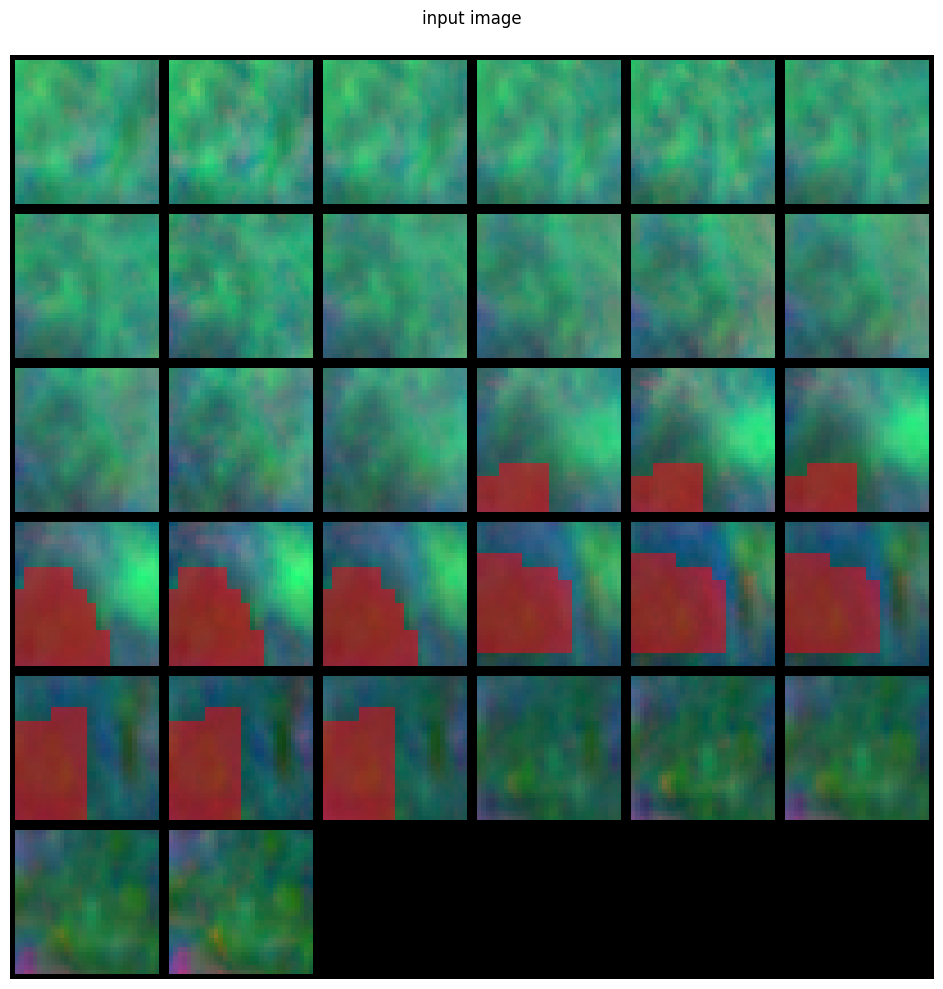

In [ ]:
#Check transforms
img=train_transforms(train_files[1])
print(img[0]["image"].shape)

image = monai.visualize.utils.blend_images(
            img[0]["image"],
            img[0]["label"],
            alpha=0.5,
            cmap="hsv",
            rescale_arrays=True,
            transparent_background=True,
        )

matshow3d(
    volume=image,
    fig=None,
    title="input image",
    every_n=1,
    frame_dim=-1,
    show=True,
    channel_dim=0,
)
plt.show()

In [ ]:
## Creating Datasets

train_ds = CacheDataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

test_ds = CacheDataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

Loading dataset: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


In [ ]:
# Defining Model and Metrics

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Working on device: {device}")

UNet_meatdata = dict(
    spatial_dims=3,
    in_channels=3,
    out_channels=2,
    channels=[16, 32, 64, 128, 256, 512],
    strides=[2, 2, 2, 2, 2],
    num_res_units=4,
    norm="batch",
    act="PReLU",
    dropout=0.15,
)

model = UNet(**UNet_meatdata).to(device)
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=3e-5)

Working on device: cuda


In [ ]:
data_in = (train_loader, test_loader)
model_dir = "./model_results"


post_label = monai.transforms.AsDiscrete(to_onehot=2)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
iou_metric = monai.metrics.MeanIoU(
    include_background=False, reduction="mean", get_not_nans=False
)

In [ ]:
train(
    model=model,
    data_in=(train_loader, test_loader),
    loss=loss_function,
    optim=optimizer,
    max_epochs=50,
    model_dir=model_dir,
    device=device,
    name="Prostate158_labeler1",
    test_interval=1,
    start_epoch=0,
)

--------------------------------------------------
2024-07-03 15:41:00 - epoch 1/50


2024-07-03 15:41:08 - Epoch 1: 100%|██████████| 29/29 [00:07<00:00,  3.85batch/s, dice_score=0.382, loss=0.839]


--------------------
Epoch_loss: 0.8790
Epoch_metric: 0.3817
IoU_metric: 0.2529


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.7480
test_dice_epoch: 0.0634
test_dice_epoch_per_class:
	csPCa: 0.06341105699539185
test_iou_epoch: 0.0350
test_iou_epoch_per_class:
	csPCa: 0.034975919872522354
current epoch: 1 current mean dice: 0.0634
best mean dice: 0.0634 at epoch: 1
--------------------------------------------------
2024-07-03 15:41:51 - epoch 2/50


2024-07-03 15:41:59 - Epoch 2: 100%|██████████| 29/29 [00:07<00:00,  3.73batch/s, dice_score=0.395, loss=0.747]


--------------------
Epoch_loss: 0.8470
Epoch_metric: 0.3950
IoU_metric: 0.2639


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


test_loss_epoch: 0.7411
test_dice_epoch: 0.0844
test_dice_epoch_per_class:
	csPCa: 0.08442724496126175
test_iou_epoch: 0.0485
test_iou_epoch_per_class:
	csPCa: 0.04846828803420067
current epoch: 2 current mean dice: 0.0844
best mean dice: 0.0844 at epoch: 2
--------------------------------------------------
2024-07-03 15:42:45 - epoch 3/50


2024-07-03 15:42:53 - Epoch 3: 100%|██████████| 29/29 [00:07<00:00,  3.71batch/s, dice_score=0.395, loss=1.02]


--------------------
Epoch_loss: 0.8553
Epoch_metric: 0.3949
IoU_metric: 0.2616


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.7118
test_dice_epoch: 0.0648
test_dice_epoch_per_class:
	csPCa: 0.06478320807218552
test_iou_epoch: 0.0360
test_iou_epoch_per_class:
	csPCa: 0.03598920255899429
current epoch: 3 current mean dice: 0.0648
best mean dice: 0.0844 at epoch: 2
--------------------------------------------------
2024-07-03 15:43:39 - epoch 4/50


2024-07-03 15:43:47 - Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.43batch/s, dice_score=0.448, loss=0.712]


--------------------
Epoch_loss: 0.7900
Epoch_metric: 0.4477
IoU_metric: 0.3035


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.7139
test_dice_epoch: 0.0832
test_dice_epoch_per_class:
	csPCa: 0.08316612243652344
test_iou_epoch: 0.0474
test_iou_epoch_per_class:
	csPCa: 0.04740244150161743
current epoch: 4 current mean dice: 0.0832
best mean dice: 0.0844 at epoch: 2
--------------------------------------------------
2024-07-03 15:44:27 - epoch 5/50


2024-07-03 15:44:35 - Epoch 5: 100%|██████████| 29/29 [00:07<00:00,  3.82batch/s, dice_score=0.427, loss=0.714]


--------------------
Epoch_loss: 0.7778
Epoch_metric: 0.4271
IoU_metric: 0.2896


100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


test_loss_epoch: 0.7028
test_dice_epoch: 0.0799
test_dice_epoch_per_class:
	csPCa: 0.0798976868391037
test_iou_epoch: 0.0453
test_iou_epoch_per_class:
	csPCa: 0.04534441977739334
current epoch: 5 current mean dice: 0.0799
best mean dice: 0.0844 at epoch: 2
--------------------------------------------------
2024-07-03 15:45:13 - epoch 6/50


2024-07-03 15:45:20 - Epoch 6: 100%|██████████| 29/29 [00:07<00:00,  3.68batch/s, dice_score=0.401, loss=0.768]


--------------------
Epoch_loss: 0.7751
Epoch_metric: 0.4012
IoU_metric: 0.2691


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.6543
test_dice_epoch: 0.0833
test_dice_epoch_per_class:
	csPCa: 0.0832904577255249
test_iou_epoch: 0.0477
test_iou_epoch_per_class:
	csPCa: 0.047662846744060516
current epoch: 6 current mean dice: 0.0833
best mean dice: 0.0844 at epoch: 2
--------------------------------------------------
2024-07-03 15:46:02 - epoch 7/50


2024-07-03 15:46:10 - Epoch 7: 100%|██████████| 29/29 [00:08<00:00,  3.39batch/s, dice_score=0.4, loss=0.7]


--------------------
Epoch_loss: 0.7563
Epoch_metric: 0.3997
IoU_metric: 0.2693


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.6520
test_dice_epoch: 0.0889
test_dice_epoch_per_class:
	csPCa: 0.08890856802463531
test_iou_epoch: 0.0511
test_iou_epoch_per_class:
	csPCa: 0.05107699707150459
current epoch: 7 current mean dice: 0.0889
best mean dice: 0.0889 at epoch: 7
--------------------------------------------------
2024-07-03 15:46:51 - epoch 8/50


2024-07-03 15:46:59 - Epoch 8: 100%|██████████| 29/29 [00:07<00:00,  3.93batch/s, dice_score=0.389, loss=1.63]


--------------------
Epoch_loss: 0.7854
Epoch_metric: 0.3887
IoU_metric: 0.2590


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.6380
test_dice_epoch: 0.0827
test_dice_epoch_per_class:
	csPCa: 0.08267468214035034
test_iou_epoch: 0.0473
test_iou_epoch_per_class:
	csPCa: 0.04730736464262009
current epoch: 8 current mean dice: 0.0827
best mean dice: 0.0889 at epoch: 7
--------------------------------------------------
2024-07-03 15:47:36 - epoch 9/50


2024-07-03 15:47:45 - Epoch 9: 100%|██████████| 29/29 [00:08<00:00,  3.47batch/s, dice_score=0.414, loss=0.69]


--------------------
Epoch_loss: 0.7386
Epoch_metric: 0.4137
IoU_metric: 0.2812


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.6490
test_dice_epoch: 0.0877
test_dice_epoch_per_class:
	csPCa: 0.08774564415216446
test_iou_epoch: 0.0502
test_iou_epoch_per_class:
	csPCa: 0.050243448466062546
current epoch: 9 current mean dice: 0.0877
best mean dice: 0.0889 at epoch: 7
--------------------------------------------------
2024-07-03 15:48:30 - epoch 10/50


2024-07-03 15:48:38 - Epoch 10: 100%|██████████| 29/29 [00:07<00:00,  3.72batch/s, dice_score=0.438, loss=0.712]


--------------------
Epoch_loss: 0.7256
Epoch_metric: 0.4383
IoU_metric: 0.3006


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.6494
test_dice_epoch: 0.0980
test_dice_epoch_per_class:
	csPCa: 0.0979597419500351
test_iou_epoch: 0.0567
test_iou_epoch_per_class:
	csPCa: 0.05673037841916084
current epoch: 10 current mean dice: 0.0980
best mean dice: 0.0980 at epoch: 10
--------------------------------------------------
2024-07-03 15:49:18 - epoch 11/50


2024-07-03 15:49:26 - Epoch 11: 100%|██████████| 29/29 [00:08<00:00,  3.26batch/s, dice_score=0.41, loss=0.811]


--------------------
Epoch_loss: 0.7190
Epoch_metric: 0.4099
IoU_metric: 0.2815


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


test_loss_epoch: 0.6348
test_dice_epoch: 0.0977
test_dice_epoch_per_class:
	csPCa: 0.09768380224704742
test_iou_epoch: 0.0566
test_iou_epoch_per_class:
	csPCa: 0.05664009600877762
current epoch: 11 current mean dice: 0.0977
best mean dice: 0.0980 at epoch: 10
--------------------------------------------------
2024-07-03 15:50:04 - epoch 12/50


2024-07-03 15:50:12 - Epoch 12: 100%|██████████| 29/29 [00:08<00:00,  3.47batch/s, dice_score=0.399, loss=0.794]


--------------------
Epoch_loss: 0.7151
Epoch_metric: 0.3986
IoU_metric: 0.2711


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.6025
test_dice_epoch: 0.0734
test_dice_epoch_per_class:
	csPCa: 0.07340472936630249
test_iou_epoch: 0.0409
test_iou_epoch_per_class:
	csPCa: 0.04092979431152344
current epoch: 12 current mean dice: 0.0734
best mean dice: 0.0980 at epoch: 10
--------------------------------------------------
2024-07-03 15:50:54 - epoch 13/50


2024-07-03 15:51:02 - Epoch 13: 100%|██████████| 29/29 [00:08<00:00,  3.24batch/s, dice_score=0.428, loss=0.672]


--------------------
Epoch_loss: 0.7434
Epoch_metric: 0.4278
IoU_metric: 0.2900


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5808
test_dice_epoch: 0.0726
test_dice_epoch_per_class:
	csPCa: 0.07256956398487091
test_iou_epoch: 0.0407
test_iou_epoch_per_class:
	csPCa: 0.040689148008823395
current epoch: 13 current mean dice: 0.0726
best mean dice: 0.0980 at epoch: 10
--------------------------------------------------
2024-07-03 15:51:44 - epoch 14/50


2024-07-03 15:51:52 - Epoch 14: 100%|██████████| 29/29 [00:08<00:00,  3.42batch/s, dice_score=0.426, loss=0.605]


--------------------
Epoch_loss: 0.7195
Epoch_metric: 0.4261
IoU_metric: 0.2846


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5831
test_dice_epoch: 0.0843
test_dice_epoch_per_class:
	csPCa: 0.08427475392818451
test_iou_epoch: 0.0478
test_iou_epoch_per_class:
	csPCa: 0.047786641865968704
current epoch: 14 current mean dice: 0.0843
best mean dice: 0.0980 at epoch: 10
--------------------------------------------------
2024-07-03 15:52:33 - epoch 15/50


2024-07-03 15:52:42 - Epoch 15: 100%|██████████| 29/29 [00:08<00:00,  3.26batch/s, dice_score=0.423, loss=0.75]


--------------------
Epoch_loss: 0.7010
Epoch_metric: 0.4232
IoU_metric: 0.2892


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5904
test_dice_epoch: 0.0996
test_dice_epoch_per_class:
	csPCa: 0.0995643138885498
test_iou_epoch: 0.0576
test_iou_epoch_per_class:
	csPCa: 0.057627253234386444
current epoch: 15 current mean dice: 0.0996
best mean dice: 0.0996 at epoch: 15
--------------------------------------------------
2024-07-03 15:53:24 - epoch 16/50


2024-07-03 15:53:33 - Epoch 16: 100%|██████████| 29/29 [00:09<00:00,  3.22batch/s, dice_score=0.419, loss=0.732]


--------------------
Epoch_loss: 0.7072
Epoch_metric: 0.4191
IoU_metric: 0.2884


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


test_loss_epoch: 0.5695
test_dice_epoch: 0.1000
test_dice_epoch_per_class:
	csPCa: 0.09998567402362823
test_iou_epoch: 0.0581
test_iou_epoch_per_class:
	csPCa: 0.058118246495723724
current epoch: 16 current mean dice: 0.1000
best mean dice: 0.1000 at epoch: 16
--------------------------------------------------
2024-07-03 15:54:32 - epoch 17/50


2024-07-03 15:54:40 - Epoch 17: 100%|██████████| 29/29 [00:08<00:00,  3.34batch/s, dice_score=0.412, loss=0.669]


--------------------
Epoch_loss: 0.7177
Epoch_metric: 0.4120
IoU_metric: 0.2780


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5675
test_dice_epoch: 0.1037
test_dice_epoch_per_class:
	csPCa: 0.10365752875804901
test_iou_epoch: 0.0605
test_iou_epoch_per_class:
	csPCa: 0.06053541973233223
current epoch: 17 current mean dice: 0.1037
best mean dice: 0.1037 at epoch: 17
--------------------------------------------------
2024-07-03 15:55:31 - epoch 18/50


2024-07-03 15:55:41 - Epoch 18: 100%|██████████| 29/29 [00:09<00:00,  3.09batch/s, dice_score=0.404, loss=0.641]


--------------------
Epoch_loss: 0.6954
Epoch_metric: 0.4040
IoU_metric: 0.2779


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5939
test_dice_epoch: 0.1019
test_dice_epoch_per_class:
	csPCa: 0.10186827182769775
test_iou_epoch: 0.0588
test_iou_epoch_per_class:
	csPCa: 0.058814458549022675
current epoch: 18 current mean dice: 0.1019
best mean dice: 0.1037 at epoch: 17
--------------------------------------------------
2024-07-03 15:56:23 - epoch 19/50


2024-07-03 15:56:31 - Epoch 19: 100%|██████████| 29/29 [00:08<00:00,  3.51batch/s, dice_score=0.431, loss=0.638]


--------------------
Epoch_loss: 0.6822
Epoch_metric: 0.4315
IoU_metric: 0.2943


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5771
test_dice_epoch: 0.1148
test_dice_epoch_per_class:
	csPCa: 0.11478443443775177
test_iou_epoch: 0.0676
test_iou_epoch_per_class:
	csPCa: 0.06758631765842438
current epoch: 19 current mean dice: 0.1148
best mean dice: 0.1148 at epoch: 19
--------------------------------------------------
2024-07-03 15:57:26 - epoch 20/50


2024-07-03 15:57:34 - Epoch 20: 100%|██████████| 29/29 [00:08<00:00,  3.49batch/s, dice_score=0.448, loss=0.532]


--------------------
Epoch_loss: 0.6561
Epoch_metric: 0.4482
IoU_metric: 0.3099


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5706
test_dice_epoch: 0.1166
test_dice_epoch_per_class:
	csPCa: 0.11655507981777191
test_iou_epoch: 0.0684
test_iou_epoch_per_class:
	csPCa: 0.06844311952590942
current epoch: 20 current mean dice: 0.1166
best mean dice: 0.1166 at epoch: 20
--------------------------------------------------
2024-07-03 15:58:42 - epoch 21/50


2024-07-03 15:58:50 - Epoch 21: 100%|██████████| 29/29 [00:08<00:00,  3.38batch/s, dice_score=0.434, loss=0.658]


--------------------
Epoch_loss: 0.6789
Epoch_metric: 0.4342
IoU_metric: 0.2929


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5480
test_dice_epoch: 0.1021
test_dice_epoch_per_class:
	csPCa: 0.102081298828125
test_iou_epoch: 0.0594
test_iou_epoch_per_class:
	csPCa: 0.05942912772297859
current epoch: 21 current mean dice: 0.1021
best mean dice: 0.1166 at epoch: 20
--------------------------------------------------
2024-07-03 15:59:31 - epoch 22/50


2024-07-03 15:59:38 - Epoch 22: 100%|██████████| 29/29 [00:07<00:00,  3.68batch/s, dice_score=0.391, loss=0.541]


--------------------
Epoch_loss: 0.6942
Epoch_metric: 0.3909
IoU_metric: 0.2639


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5420
test_dice_epoch: 0.0914
test_dice_epoch_per_class:
	csPCa: 0.09137298166751862
test_iou_epoch: 0.0532
test_iou_epoch_per_class:
	csPCa: 0.05316096544265747
current epoch: 22 current mean dice: 0.0914
best mean dice: 0.1166 at epoch: 20
--------------------------------------------------
2024-07-03 16:00:29 - epoch 23/50


2024-07-03 16:00:38 - Epoch 23: 100%|██████████| 29/29 [00:09<00:00,  3.12batch/s, dice_score=0.417, loss=0.706]


--------------------
Epoch_loss: 0.6654
Epoch_metric: 0.4171
IoU_metric: 0.2880


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5450
test_dice_epoch: 0.1120
test_dice_epoch_per_class:
	csPCa: 0.11199770867824554
test_iou_epoch: 0.0666
test_iou_epoch_per_class:
	csPCa: 0.06659559160470963
current epoch: 23 current mean dice: 0.1120
best mean dice: 0.1166 at epoch: 20
--------------------------------------------------
2024-07-03 16:01:21 - epoch 24/50


2024-07-03 16:01:30 - Epoch 24: 100%|██████████| 29/29 [00:08<00:00,  3.30batch/s, dice_score=0.425, loss=1.48]


--------------------
Epoch_loss: 0.6933
Epoch_metric: 0.4246
IoU_metric: 0.2917


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5340
test_dice_epoch: 0.0817
test_dice_epoch_per_class:
	csPCa: 0.08171580731868744
test_iou_epoch: 0.0471
test_iou_epoch_per_class:
	csPCa: 0.04708296060562134
current epoch: 24 current mean dice: 0.0817
best mean dice: 0.1166 at epoch: 20
--------------------------------------------------
2024-07-03 16:02:07 - epoch 25/50


2024-07-03 16:02:15 - Epoch 25: 100%|██████████| 29/29 [00:08<00:00,  3.62batch/s, dice_score=0.44, loss=0.68]


--------------------
Epoch_loss: 0.6840
Epoch_metric: 0.4396
IoU_metric: 0.3090


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5513
test_dice_epoch: 0.1177
test_dice_epoch_per_class:
	csPCa: 0.11767403781414032
test_iou_epoch: 0.0700
test_iou_epoch_per_class:
	csPCa: 0.06999217718839645
current epoch: 25 current mean dice: 0.1177
best mean dice: 0.1177 at epoch: 25
--------------------------------------------------
2024-07-03 16:03:01 - epoch 26/50


2024-07-03 16:03:08 - Epoch 26: 100%|██████████| 29/29 [00:07<00:00,  3.86batch/s, dice_score=0.407, loss=0.643]


--------------------
Epoch_loss: 0.7111
Epoch_metric: 0.4066
IoU_metric: 0.2797


100%|██████████| 10/10 [00:36<00:00,  3.60s/it]


test_loss_epoch: 0.5626
test_dice_epoch: 0.1087
test_dice_epoch_per_class:
	csPCa: 0.10874883830547333
test_iou_epoch: 0.0637
test_iou_epoch_per_class:
	csPCa: 0.06372114270925522
current epoch: 26 current mean dice: 0.1087
best mean dice: 0.1177 at epoch: 25
--------------------------------------------------
2024-07-03 16:03:50 - epoch 27/50


2024-07-03 16:03:58 - Epoch 27: 100%|██████████| 29/29 [00:08<00:00,  3.42batch/s, dice_score=0.438, loss=0.852]


--------------------
Epoch_loss: 0.6741
Epoch_metric: 0.4381
IoU_metric: 0.3027


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5474
test_dice_epoch: 0.1056
test_dice_epoch_per_class:
	csPCa: 0.10561712831258774
test_iou_epoch: 0.0614
test_iou_epoch_per_class:
	csPCa: 0.061422061175107956
current epoch: 27 current mean dice: 0.1056
best mean dice: 0.1177 at epoch: 25
--------------------------------------------------
2024-07-03 16:04:39 - epoch 28/50


2024-07-03 16:04:47 - Epoch 28: 100%|██████████| 29/29 [00:08<00:00,  3.48batch/s, dice_score=0.471, loss=0.501]


--------------------
Epoch_loss: 0.6301
Epoch_metric: 0.4707
IoU_metric: 0.3282


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5359
test_dice_epoch: 0.1091
test_dice_epoch_per_class:
	csPCa: 0.10907821357250214
test_iou_epoch: 0.0643
test_iou_epoch_per_class:
	csPCa: 0.06430269777774811
current epoch: 28 current mean dice: 0.1091
best mean dice: 0.1177 at epoch: 25
--------------------------------------------------
2024-07-03 16:05:28 - epoch 29/50


2024-07-03 16:05:37 - Epoch 29: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, dice_score=0.439, loss=1.25]


--------------------
Epoch_loss: 0.6872
Epoch_metric: 0.4395
IoU_metric: 0.3038


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5407
test_dice_epoch: 0.1176
test_dice_epoch_per_class:
	csPCa: 0.11759978532791138
test_iou_epoch: 0.0696
test_iou_epoch_per_class:
	csPCa: 0.06960012763738632
current epoch: 29 current mean dice: 0.1176
best mean dice: 0.1177 at epoch: 25
--------------------------------------------------
2024-07-03 16:06:16 - epoch 30/50


2024-07-03 16:06:24 - Epoch 30: 100%|██████████| 29/29 [00:08<00:00,  3.57batch/s, dice_score=0.441, loss=0.596]


--------------------
Epoch_loss: 0.6495
Epoch_metric: 0.4410
IoU_metric: 0.3072


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5364
test_dice_epoch: 0.1170
test_dice_epoch_per_class:
	csPCa: 0.1170223206281662
test_iou_epoch: 0.0697
test_iou_epoch_per_class:
	csPCa: 0.06973210722208023
current epoch: 30 current mean dice: 0.1170
best mean dice: 0.1177 at epoch: 25
--------------------------------------------------
2024-07-03 16:07:01 - epoch 31/50


2024-07-03 16:07:10 - Epoch 31: 100%|██████████| 29/29 [00:08<00:00,  3.30batch/s, dice_score=0.475, loss=0.575]


--------------------
Epoch_loss: 0.6750
Epoch_metric: 0.4749
IoU_metric: 0.3330


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5477
test_dice_epoch: 0.1295
test_dice_epoch_per_class:
	csPCa: 0.1294817179441452
test_iou_epoch: 0.0779
test_iou_epoch_per_class:
	csPCa: 0.07791008055210114
current epoch: 31 current mean dice: 0.1295
best mean dice: 0.1295 at epoch: 31
--------------------------------------------------
2024-07-03 16:07:49 - epoch 32/50


2024-07-03 16:07:58 - Epoch 32: 100%|██████████| 29/29 [00:09<00:00,  3.22batch/s, dice_score=0.468, loss=0.572]


--------------------
Epoch_loss: 0.6577
Epoch_metric: 0.4681
IoU_metric: 0.3273


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


test_loss_epoch: 0.5550
test_dice_epoch: 0.1229
test_dice_epoch_per_class:
	csPCa: 0.12294656038284302
test_iou_epoch: 0.0732
test_iou_epoch_per_class:
	csPCa: 0.0731930136680603
current epoch: 32 current mean dice: 0.1229
best mean dice: 0.1295 at epoch: 31
--------------------------------------------------
2024-07-03 16:08:35 - epoch 33/50


2024-07-03 16:08:43 - Epoch 33: 100%|██████████| 29/29 [00:08<00:00,  3.51batch/s, dice_score=0.439, loss=0.97]


--------------------
Epoch_loss: 0.6918
Epoch_metric: 0.4388
IoU_metric: 0.3025


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5391
test_dice_epoch: 0.1289
test_dice_epoch_per_class:
	csPCa: 0.1289132535457611
test_iou_epoch: 0.0777
test_iou_epoch_per_class:
	csPCa: 0.07768889516592026
current epoch: 33 current mean dice: 0.1289
best mean dice: 0.1295 at epoch: 31
--------------------------------------------------
2024-07-03 16:09:27 - epoch 34/50


2024-07-03 16:09:34 - Epoch 34: 100%|██████████| 29/29 [00:07<00:00,  3.64batch/s, dice_score=0.446, loss=0.66]


--------------------
Epoch_loss: 0.6709
Epoch_metric: 0.4459
IoU_metric: 0.3065


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5253
test_dice_epoch: 0.1327
test_dice_epoch_per_class:
	csPCa: 0.13271352648735046
test_iou_epoch: 0.0800
test_iou_epoch_per_class:
	csPCa: 0.08000332117080688
current epoch: 34 current mean dice: 0.1327
best mean dice: 0.1327 at epoch: 34
--------------------------------------------------
2024-07-03 16:10:15 - epoch 35/50


2024-07-03 16:10:24 - Epoch 35: 100%|██████████| 29/29 [00:09<00:00,  3.11batch/s, dice_score=0.451, loss=0.688]


--------------------
Epoch_loss: 0.6941
Epoch_metric: 0.4512
IoU_metric: 0.3152


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5566
test_dice_epoch: 0.1522
test_dice_epoch_per_class:
	csPCa: 0.15215525031089783
test_iou_epoch: 0.0938
test_iou_epoch_per_class:
	csPCa: 0.09384258091449738
current epoch: 35 current mean dice: 0.1522
best mean dice: 0.1522 at epoch: 35
--------------------------------------------------
2024-07-03 16:11:18 - epoch 36/50


2024-07-03 16:11:27 - Epoch 36: 100%|██████████| 29/29 [00:08<00:00,  3.24batch/s, dice_score=0.425, loss=0.523]


--------------------
Epoch_loss: 0.6581
Epoch_metric: 0.4254
IoU_metric: 0.2949


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5431
test_dice_epoch: 0.1393
test_dice_epoch_per_class:
	csPCa: 0.1392606943845749
test_iou_epoch: 0.0845
test_iou_epoch_per_class:
	csPCa: 0.08452097326517105
current epoch: 36 current mean dice: 0.1393
best mean dice: 0.1522 at epoch: 35
--------------------------------------------------
2024-07-03 16:12:04 - epoch 37/50


2024-07-03 16:12:12 - Epoch 37: 100%|██████████| 29/29 [00:08<00:00,  3.62batch/s, dice_score=0.438, loss=0.629]


--------------------
Epoch_loss: 0.6582
Epoch_metric: 0.4383
IoU_metric: 0.3002


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5282
test_dice_epoch: 0.1414
test_dice_epoch_per_class:
	csPCa: 0.14140169322490692
test_iou_epoch: 0.0869
test_iou_epoch_per_class:
	csPCa: 0.08691425621509552
current epoch: 37 current mean dice: 0.1414
best mean dice: 0.1522 at epoch: 35
--------------------------------------------------
2024-07-03 16:12:53 - epoch 38/50


2024-07-03 16:13:01 - Epoch 38: 100%|██████████| 29/29 [00:08<00:00,  3.45batch/s, dice_score=0.444, loss=0.534]


--------------------
Epoch_loss: 0.6536
Epoch_metric: 0.4438
IoU_metric: 0.3121


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5366
test_dice_epoch: 0.1421
test_dice_epoch_per_class:
	csPCa: 0.1421448290348053
test_iou_epoch: 0.0873
test_iou_epoch_per_class:
	csPCa: 0.08728008717298508
current epoch: 38 current mean dice: 0.1421
best mean dice: 0.1522 at epoch: 35
--------------------------------------------------
2024-07-03 16:13:39 - epoch 39/50


2024-07-03 16:13:48 - Epoch 39: 100%|██████████| 29/29 [00:09<00:00,  3.20batch/s, dice_score=0.466, loss=0.511]


--------------------
Epoch_loss: 0.6647
Epoch_metric: 0.4657
IoU_metric: 0.3268


100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


test_loss_epoch: 0.5329
test_dice_epoch: 0.1407
test_dice_epoch_per_class:
	csPCa: 0.14066919684410095
test_iou_epoch: 0.0858
test_iou_epoch_per_class:
	csPCa: 0.08577457815408707
current epoch: 39 current mean dice: 0.1407
best mean dice: 0.1522 at epoch: 35
--------------------------------------------------
2024-07-03 16:14:30 - epoch 40/50


2024-07-03 16:14:39 - Epoch 40: 100%|██████████| 29/29 [00:08<00:00,  3.25batch/s, dice_score=0.487, loss=0.565]


--------------------
Epoch_loss: 0.6589
Epoch_metric: 0.4869
IoU_metric: 0.3410


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


test_loss_epoch: 0.5404
test_dice_epoch: 0.1556
test_dice_epoch_per_class:
	csPCa: 0.1556277722120285
test_iou_epoch: 0.0968
test_iou_epoch_per_class:
	csPCa: 0.09682340174913406
current epoch: 40 current mean dice: 0.1556
best mean dice: 0.1556 at epoch: 40
--------------------------------------------------
2024-07-03 16:15:18 - epoch 41/50


2024-07-03 16:15:26 - Epoch 41: 100%|██████████| 29/29 [00:08<00:00,  3.46batch/s, dice_score=0.414, loss=0.516]


--------------------
Epoch_loss: 0.7082
Epoch_metric: 0.4136
IoU_metric: 0.2838


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5512
test_dice_epoch: 0.1531
test_dice_epoch_per_class:
	csPCa: 0.15308114886283875
test_iou_epoch: 0.0940
test_iou_epoch_per_class:
	csPCa: 0.09402447938919067
current epoch: 41 current mean dice: 0.1531
best mean dice: 0.1556 at epoch: 40
--------------------------------------------------
2024-07-03 16:16:04 - epoch 42/50


2024-07-03 16:16:13 - Epoch 42: 100%|██████████| 29/29 [00:08<00:00,  3.25batch/s, dice_score=0.45, loss=0.502]


--------------------
Epoch_loss: 0.6523
Epoch_metric: 0.4496
IoU_metric: 0.3131


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5203
test_dice_epoch: 0.1287
test_dice_epoch_per_class:
	csPCa: 0.1286703646183014
test_iou_epoch: 0.0781
test_iou_epoch_per_class:
	csPCa: 0.07805934548377991
current epoch: 42 current mean dice: 0.1287
best mean dice: 0.1556 at epoch: 40
--------------------------------------------------
2024-07-03 16:16:56 - epoch 43/50


2024-07-03 16:17:04 - Epoch 43: 100%|██████████| 29/29 [00:08<00:00,  3.39batch/s, dice_score=0.48, loss=0.715]


--------------------
Epoch_loss: 0.6461
Epoch_metric: 0.4800
IoU_metric: 0.3363


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5381
test_dice_epoch: 0.1591
test_dice_epoch_per_class:
	csPCa: 0.15911659598350525
test_iou_epoch: 0.0990
test_iou_epoch_per_class:
	csPCa: 0.09904894232749939
current epoch: 43 current mean dice: 0.1591
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:17:55 - epoch 44/50


2024-07-03 16:18:03 - Epoch 44: 100%|██████████| 29/29 [00:08<00:00,  3.48batch/s, dice_score=0.461, loss=0.549]


--------------------
Epoch_loss: 0.6522
Epoch_metric: 0.4611
IoU_metric: 0.3277


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5215
test_dice_epoch: 0.1479
test_dice_epoch_per_class:
	csPCa: 0.14785489439964294
test_iou_epoch: 0.0920
test_iou_epoch_per_class:
	csPCa: 0.09204354137182236
current epoch: 44 current mean dice: 0.1479
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:18:46 - epoch 45/50


2024-07-03 16:18:54 - Epoch 45: 100%|██████████| 29/29 [00:08<00:00,  3.54batch/s, dice_score=0.444, loss=0.59]


--------------------
Epoch_loss: 0.6597
Epoch_metric: 0.4445
IoU_metric: 0.3103


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5433
test_dice_epoch: 0.1524
test_dice_epoch_per_class:
	csPCa: 0.15241025388240814
test_iou_epoch: 0.0934
test_iou_epoch_per_class:
	csPCa: 0.09343729168176651
current epoch: 45 current mean dice: 0.1524
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:19:36 - epoch 46/50


2024-07-03 16:19:44 - Epoch 46: 100%|██████████| 29/29 [00:08<00:00,  3.52batch/s, dice_score=0.462, loss=0.566]


--------------------
Epoch_loss: 0.6375
Epoch_metric: 0.4621
IoU_metric: 0.3233


100%|██████████| 10/10 [00:36<00:00,  3.60s/it]


test_loss_epoch: 0.5374
test_dice_epoch: 0.1381
test_dice_epoch_per_class:
	csPCa: 0.13807179033756256
test_iou_epoch: 0.0826
test_iou_epoch_per_class:
	csPCa: 0.08259770274162292
current epoch: 46 current mean dice: 0.1381
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:20:22 - epoch 47/50


2024-07-03 16:20:31 - Epoch 47: 100%|██████████| 29/29 [00:08<00:00,  3.35batch/s, dice_score=0.437, loss=0.601]


--------------------
Epoch_loss: 0.6336
Epoch_metric: 0.4370
IoU_metric: 0.3014


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


test_loss_epoch: 0.5357
test_dice_epoch: 0.1585
test_dice_epoch_per_class:
	csPCa: 0.1585199385881424
test_iou_epoch: 0.0982
test_iou_epoch_per_class:
	csPCa: 0.09820359945297241
current epoch: 47 current mean dice: 0.1585
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:21:08 - epoch 48/50


2024-07-03 16:21:16 - Epoch 48: 100%|██████████| 29/29 [00:08<00:00,  3.62batch/s, dice_score=0.468, loss=0.881]


--------------------
Epoch_loss: 0.6560
Epoch_metric: 0.4680
IoU_metric: 0.3277


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


test_loss_epoch: 0.5287
test_dice_epoch: 0.1451
test_dice_epoch_per_class:
	csPCa: 0.14509880542755127
test_iou_epoch: 0.0887
test_iou_epoch_per_class:
	csPCa: 0.08866036683320999
current epoch: 48 current mean dice: 0.1451
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:21:58 - epoch 49/50


2024-07-03 16:22:06 - Epoch 49: 100%|██████████| 29/29 [00:08<00:00,  3.57batch/s, dice_score=0.475, loss=0.502]


--------------------
Epoch_loss: 0.6410
Epoch_metric: 0.4753
IoU_metric: 0.3368


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


test_loss_epoch: 0.5313
test_dice_epoch: 0.1436
test_dice_epoch_per_class:
	csPCa: 0.14364361763000488
test_iou_epoch: 0.0873
test_iou_epoch_per_class:
	csPCa: 0.08728984743356705
current epoch: 49 current mean dice: 0.1436
best mean dice: 0.1591 at epoch: 43
--------------------------------------------------
2024-07-03 16:22:48 - epoch 50/50


2024-07-03 16:22:57 - Epoch 50: 100%|██████████| 29/29 [00:09<00:00,  3.22batch/s, dice_score=0.476, loss=0.677]


--------------------
Epoch_loss: 0.6254
Epoch_metric: 0.4757
IoU_metric: 0.3336


100%|██████████| 10/10 [00:35<00:00,  3.52s/it]

test_loss_epoch: 0.5214
test_dice_epoch: 0.1452
test_dice_epoch_per_class:
	csPCa: 0.14518508315086365
test_iou_epoch: 0.0888
test_iou_epoch_per_class:
	csPCa: 0.08878084272146225
current epoch: 50 current mean dice: 0.1452
best mean dice: 0.1591 at epoch: 43
train completed, best_metric: 0.1591 at epoch: 43


# Check TGSE Loss

In [ ]:
from tensorflow.keras.losses import Loss
import tensorflow as tf
import numpy as np

In [ ]:
from dataclasses import dataclass
from typing import Any

import keras.backend as K
import tensorflow as tf
from keras.losses import Loss
from tensorflow import cast
from tensorflow import float32 as tf_float32

TARGET_DATA_TYPE = tf_float32


@dataclass
class TcgeConfig_tf:
    """
    TCGE configuration parameters.
    """

    num_annotators: int = 5
    num_classes: int = 2
    gamma: float = 0.1


class TcgeSs_tf(Loss):  # type: ignore
    """
    Truncated generalized cross entropy
    for semantic segmentation loss.
    """

    def __init__(
        self,
        config: TcgeConfig_tf,
        q: float = 0.1,
        name: str = "TGCE_SS",
        smooth: float = 1e-5,
    ) -> None:
        self.q = q
        self.num_annotators = config.num_annotators
        self.num_classes = config.num_classes
        self.smooth = smooth
        self.gamma = config.gamma
        super().__init__(name=name)

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        y_true = cast(y_true, TARGET_DATA_TYPE)
        y_pred = cast(y_pred, TARGET_DATA_TYPE)

        y_pred = y_pred[..., : self.num_classes + self.num_annotators]  # type:ignore
        y_true = tf.reshape(
            y_true, (y_true.shape[:-1]) + (self.num_classes, self.num_annotators)
        )
        lambda_r = y_pred[..., self.num_classes :]  # type:ignore
        y_pred_ = y_pred[..., : self.num_classes]
        n_samples, width, height, _ = y_pred_.shape
        y_pred_ = y_pred_[..., tf.newaxis]  # type:ignore
        y_pred_ = tf.repeat(y_pred_, repeats=[self.num_annotators], axis=-1)

        epsilon = 1e-8
        y_pred_ = tf.clip_by_value(y_pred_, epsilon, 1.0 - epsilon)

        term_r = tf.math.reduce_mean(
            tf.math.multiply(
                y_true,
                (
                    tf.ones(
                        [
                            n_samples,
                            width,
                            height,
                            self.num_classes,
                            self.num_annotators,
                        ]
                    )
                    - tf.pow(y_pred_, self.q)
                )
                / (self.q + epsilon + self.smooth),
            ),
            axis=-2,
        )

        term_c = tf.math.multiply(
            tf.ones([n_samples, width, height, self.num_annotators]) - lambda_r,
            (
                tf.ones([n_samples, width, height, self.num_annotators])
                - tf.pow(
                    (1 / self.num_classes + self.smooth)
                    * tf.ones([n_samples, width, height, self.num_annotators]),
                    self.q,
                )
            )
            / (self.q + epsilon + self.smooth),
        )

        loss = tf.math.reduce_mean(tf.math.multiply(lambda_r, term_r) + term_c)
        loss = tf.where(tf.math.is_nan(loss), tf.constant(1e-8), loss)

        return loss

    def get_config(
        self,
    ) -> Any:
        """
        Retrieves loss configuration.
        """
        base_config = super().get_config()
        return {**base_config, "q": self.q}

In [ ]:
# Simulate data
batch_size = 2
height = 128
width = 128
num_classes = 2
num_annotators = 5

# Simulated ground truth
y_true = np.random.randint(0, num_classes, size=(batch_size, height, width, num_classes*num_annotators))
y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

# Simulated predictions: concatenated segmented images and annotator reliability scores
y_pred_segmented = np.random.rand(batch_size, height, width, num_classes).astype(np.float32)
y_pred_reliability = np.random.rand(batch_size, height, width, num_annotators).astype(np.float32)
y_pred = np.concatenate((y_pred_segmented, y_pred_reliability), axis=-1)
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

# Instantiate the loss function
config = TcgeConfig_tf(num_annotators=num_annotators, num_classes=num_classes)
loss_fn = TcgeSs_tf(config=config)

# Compute the loss
loss_value = loss_fn(y_true, y_pred)

# Print the results
print("Loss value:", loss_value.numpy())

Loss value: 0.5605929


## PyTorch Version of Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TcgeConfig_pytorch:
    """
    TCGE configuration parameters.
    """
    def __init__(self, num_annotators=5, num_classes=2, gamma=0.1):
        self.num_annotators = num_annotators
        self.num_classes = num_classes
        self.gamma = gamma

class TcgeSs_pytorch(nn.Module):
    """
    Truncated generalized cross entropy for semantic segmentation loss.
    """
    def __init__(self, config, q=0.1, smooth=1e-5):
        super(TcgeSs_pytorch, self).__init__()
        self.q = q
        self.num_annotators = config.num_annotators
        self.num_classes = config.num_classes
        self.smooth = smooth
        self.gamma = config.gamma

    def forward(self, y_true, y_pred):
        y_true = y_true.to(torch.float32)
        y_pred = y_pred.to(torch.float32)

        y_pred = y_pred[..., :self.num_classes + self.num_annotators]

        y_true = y_true.view(y_true.shape[:-1] + (self.num_classes, self.num_annotators))

        lambda_r = y_pred[..., self.num_classes:]
        y_pred_ = y_pred[..., :self.num_classes]
        n_samples, width, height, _ = y_pred_.shape

        y_pred_ = y_pred_.unsqueeze(-1)
        y_pred_ = y_pred_.repeat(1, 1, 1, 1, self.num_annotators)

        epsilon = 1e-8
        y_pred_ = torch.clamp(y_pred_, epsilon, 1.0 - epsilon)

        term_r = torch.mean(
            torch.mul(
                y_true,
                (torch.ones((n_samples, width, height, self.num_classes, self.num_annotators)) - torch.pow(y_pred_, self.q))
                / (self.q + epsilon + self.smooth)
            ),
            dim=-2
        )

        term_c = torch.mul(
            torch.ones((n_samples, width, height, self.num_annotators)) - lambda_r,
            (
                torch.ones((n_samples, width, height, self.num_annotators))
                - torch.pow((1 / self.num_classes + self.smooth) * torch.ones((n_samples, width, height, self.num_annotators)), self.q)
            )
            / (self.q + epsilon + self.smooth)
        )

        loss = torch.mean(torch.mul(lambda_r, term_r) + term_c)
        loss = torch.where(torch.isnan(loss), torch.tensor(1e-8, dtype=loss.dtype, device=loss.device), loss)

        return loss

In [ ]:
import numpy as np

# Simulate data
batch_size = 2
height = 128
width = 128
num_classes = 2
num_annotators = 5

# Simulated ground truth
y_true_segmented = np.random.randint(0, num_classes, size=(batch_size, height, width))
y_true_one_hot = np.eye(num_classes)[y_true_segmented]
y_true_one_hot = np.repeat(y_true_one_hot[..., np.newaxis], num_annotators, axis=-1)  # Shape: (batch_size, height, width, num_classes, num_annotators)
y_true_one_hot = np.moveaxis(y_true_one_hot, -1, -2)  # Shape: (batch_size, height, width, num_annotators, num_classes)
y_true_one_hot = y_true_one_hot.reshape(batch_size, height, width, num_classes * num_annotators)  # Shape: (batch_size, height, width, num_classes * num_annotators)

# Simulated predictions: concatenated segmented images and annotator reliability scores
y_pred_segmented = np.random.rand(batch_size, height, width, num_classes).astype(np.float32)
y_pred_reliability = np.random.rand(batch_size, height, width, num_annotators).astype(np.float32)
y_pred = np.concatenate((y_pred_segmented, y_pred_reliability), axis=-1)  # Shape: (batch_size, height, width, num_classes + num_annotators)


In [ ]:
# Convert to TensorFlow tensors
y_true_tf = tf.convert_to_tensor(y_true_one_hot, dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float32)

# Instantiate the loss function
config = TcgeConfig_tf(num_annotators=num_annotators, num_classes=num_classes)
loss_fn_tf = TcgeSs_tf(config)

# Compute the loss
loss_value_tf = loss_fn_tf(y_true_tf, y_pred_tf)



In [ ]:
# Convert to PyTorch tensors
y_true_pt = torch.tensor(y_true_one_hot, dtype=torch.float32)
y_pred_pt = torch.tensor(y_pred, dtype=torch.float32)

# Instantiate the loss function
config = TcgeConfig_pytorch(num_annotators=num_annotators, num_classes=num_classes)
loss_fn_pt = TcgeSs_pytorch(config)

# Compute the loss
loss_value_pt = loss_fn_pt(y_true_pt, y_pred_pt)



In [ ]:
# Print both loss values to compare
print(f"TensorFlow Loss value: {loss_value_tf.numpy()}")
print(f"PyTorch Loss value: {loss_value_pt.item()}")

TensorFlow Loss value: 0.5624853372573853
PyTorch Loss value: 0.5624853372573853


## Testing 3D images

In [ ]:
from dataclasses import dataclass
from typing import Any

import keras.backend as K
import tensorflow as tf
from keras.losses import Loss
from tensorflow import cast
from tensorflow import float32 as tf_float32

TARGET_DATA_TYPE = tf_float32


@dataclass
class TcgeConfig_tf_3D:
    """
    TCGE configuration parameters.
    """

    num_annotators: int = 5
    num_classes: int = 2
    gamma: float = 0.1


class TcgeSs_tf_3D(Loss):  # type: ignore
    """
    Truncated generalized cross entropy
    for semantic segmentation loss.
    """

    def __init__(
        self,
        config: TcgeConfig_tf_3D,
        q: float = 0.1,
        name: str = "TGCE_SS",
        smooth: float = 1e-5,
    ) -> None:
        self.q = q
        self.num_annotators = config.num_annotators
        self.num_classes = config.num_classes
        self.smooth = smooth
        self.gamma = config.gamma
        super().__init__(name=name)

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        y_true = cast(y_true, TARGET_DATA_TYPE)
        y_pred = cast(y_pred, TARGET_DATA_TYPE)

        y_pred = y_pred[..., : self.num_classes + self.num_annotators]  # type:ignore
        y_true = tf.reshape(
            y_true, (y_true.shape[:-1]) + (self.num_classes, self.num_annotators)
        )
        lambda_r = y_pred[..., self.num_classes :]  # type:ignore
        y_pred_ = y_pred[..., : self.num_classes]
        n_samples, depth, width, height, _ = y_pred_.shape
        y_pred_ = y_pred_[..., tf.newaxis]  # type:ignore
        y_pred_ = tf.repeat(y_pred_, repeats=[self.num_annotators], axis=-1)

        epsilon = 1e-8
        y_pred_ = tf.clip_by_value(y_pred_, epsilon, 1.0 - epsilon)

        term_r = tf.math.reduce_mean(
            tf.math.multiply(
                y_true,
                (
                    tf.ones(
                        [
                            n_samples,
                            depth,
                            width,
                            height,
                            self.num_classes,
                            self.num_annotators,
                        ]
                    )
                    - tf.pow(y_pred_, self.q)
                )
                / (self.q + epsilon + self.smooth),
            ),
            axis=-2,
        )

        term_c = tf.math.multiply(
            tf.ones([n_samples,depth, width, height, self.num_annotators]) - lambda_r,
            (
                tf.ones([n_samples,depth, width, height, self.num_annotators])
                - tf.pow(
                    (1 / self.num_classes + self.smooth)
                    * tf.ones([n_samples,depth, width, height, self.num_annotators]),
                    self.q,
                )
            )
            / (self.q + epsilon + self.smooth),
        )

        loss = tf.math.reduce_mean(tf.math.multiply(lambda_r, term_r) + term_c)
        loss = tf.where(tf.math.is_nan(loss), tf.constant(1e-8), loss)

        return loss

    def get_config(
        self,
    ) -> Any:
        """
        Retrieves loss configuration.
        """
        base_config = super().get_config()
        return {**base_config, "q": self.q}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TcgeConfig_pytorch_3D:
    """
    TCGE configuration parameters.
    """
    def __init__(self, num_annotators=5, num_classes=2, gamma=0.1):
        self.num_annotators = num_annotators
        self.num_classes = num_classes
        self.gamma = gamma

class TcgeSs_pytorch_3D(nn.Module):
    """
    Truncated generalized cross entropy for semantic segmentation loss.
    """
    def __init__(self, config, q=0.1, smooth=1e-5):
        super(TcgeSs_pytorch_3D, self).__init__()
        self.q = q
        self.num_annotators = config.num_annotators
        self.num_classes = config.num_classes
        self.smooth = smooth
        self.gamma = config.gamma

    def forward(self, y_true, y_pred):
        y_true = y_true.to(torch.float32)
        y_pred = y_pred.to(torch.float32)

        y_pred = y_pred[..., :self.num_classes + self.num_annotators]

        y_true = y_true.view(y_true.shape[:-1] + (self.num_classes, self.num_annotators))

        lambda_r = y_pred[..., self.num_classes:]
        y_pred_ = y_pred[..., :self.num_classes]
        n_samples,depth, width, height, _ = y_pred_.shape

        y_pred_ = y_pred_.unsqueeze(-1)
        y_pred_ = y_pred_.repeat(1, 1, 1, 1, 1, self.num_annotators)

        epsilon = 1e-8
        y_pred_ = torch.clamp(y_pred_, epsilon, 1.0 - epsilon)

        term_r = torch.mean(
            torch.mul(
                y_true,
                (torch.ones((n_samples,depth, width, height, self.num_classes, self.num_annotators)) - torch.pow(y_pred_, self.q))
                / (self.q + epsilon + self.smooth)
            ),
            dim=-2
        )

        term_c = torch.mul(
            torch.ones((n_samples,depth, width, height, self.num_annotators)) - lambda_r,
            (
                torch.ones((n_samples,depth, width, height, self.num_annotators))
                - torch.pow((1 / self.num_classes + self.smooth) * torch.ones((n_samples,depth, width, height, self.num_annotators)), self.q)
            )
            / (self.q + epsilon + self.smooth)
        )

        loss = torch.mean(torch.mul(lambda_r, term_r) + term_c)
        loss = torch.where(torch.isnan(loss), torch.tensor(1e-8, dtype=loss.dtype, device=loss.device), loss)

        return loss

In [ ]:
# Simulate data
import numpy as np
batch_size = 2
depth = 32
height = 32
width = 32
channels = 3
num_classes = 2
num_annotators = 5

# Simulated ground truth
y_true_segmented = np.random.randint(0, num_classes, size=(batch_size, depth, height, width))
y_true_one_hot = np.eye(num_classes)[y_true_segmented]
y_true_one_hot = np.repeat(y_true_one_hot[..., np.newaxis], num_annotators, axis=-1)  # Shape: (batch_size, depth, height, width, num_classes, num_annotators)
y_true_one_hot = np.moveaxis(y_true_one_hot, -1, -2)  # Shape: (batch_size, depth, height, width, num_annotators, num_classes)
y_true_one_hot = y_true_one_hot.reshape(batch_size, depth, height, width, num_classes * num_annotators)  # Shape: (batch_size, depth, height, width, num_classes * num_annotators)

# Simulated predictions: concatenated segmented images and annotator reliability scores
y_pred_segmented = np.random.rand(batch_size, depth, height, width, num_classes).astype(np.float32)
y_pred_reliability = np.random.rand(batch_size, depth, height, width, num_annotators).astype(np.float32)
y_pred = np.concatenate((y_pred_segmented, y_pred_reliability), axis=-1)  # Shape: (batch_size, depth, height, width, num_classes + num_annotators)

In [ ]:
# Convert to TensorFlow tensors
y_true_tf = tf.convert_to_tensor(y_true_one_hot, dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float32)

# Instantiate the loss function
config = TcgeConfig_tf_3D(num_annotators=num_annotators, num_classes=num_classes)
loss_fn_tf = TcgeSs_tf_3D(config)

# Compute the loss
loss_value_tf = loss_fn_tf(y_true_tf, y_pred_tf)

In [ ]:
y_pred_tf.shape

TensorShape([2, 32, 32, 32, 7])

In [ ]:
# Convert to PyTorch tensors
y_true_pt = torch.tensor(y_true_one_hot, dtype=torch.float32)
y_pred_pt = torch.tensor(y_pred, dtype=torch.float32)

# Instantiate the loss function
config = TcgeConfig_pytorch_3D(num_annotators=num_annotators, num_classes=num_classes)
loss_fn_pt = TcgeSs_pytorch_3D(config)

# Compute the loss
loss_value_pt = loss_fn_pt(y_true_pt, y_pred_pt)

In [ ]:
y_true_pt.shape

torch.Size([2, 32, 32, 32, 4])

In [ ]:
# Print both loss values to compare
print(f"TensorFlow Loss value: {loss_value_tf.numpy()}")
print(f"PyTorch Loss value: {loss_value_pt.item()}")

TensorFlow Loss value: 0.5620188117027283
PyTorch Loss value: 0.5620188117027283


# Train Model Loss Function

In [ ]:
import os
import argparse

from tqdm import tqdm
import json

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    CropForegroundd,
    RandAffined,
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureChannelFirstd,
    SpatialPadd,
    ToTensord,
    RandCropByPosNegLabeld,
    RandGaussianNoised,
    RandAdjustContrastd,
    RandFlipd,
    RandGaussianSmoothd,
    RandRotated,
    AsDiscreted,
    ResampleToMatchd,
    ConcatItemsd,
    ConcatItemsd,
    ScaleIntensityd,
    Transposed,
    Lambdad
)
import monai
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    CacheDataset,
    Dataset,
    decollate_batch,
    set_track_meta,
)
from monai.visualize import matshow3d
import matplotlib.pyplot as plt
import pandas as pd


import torch
import numpy as np
from time import sleep

from datetime import datetime

In [ ]:
def custom_print(*args, **kwargs):
    # Get the current datetime
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    # Construct the message with the datetime
    formatted_message = f"{current_time} - {' '.join(map(str, args))}"
    # Use the built-in print function to display the message
    print(formatted_message, **kwargs)

# Train Function
def train_Multiple_Annotators(
    model,
    data_in,
    loss,
    optim,
    max_epochs,
    model_dir,
    device,
    name,
    test_interval=1,
    start_epoch=0,
):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    save_metric_test_per_class = []
    save_iou_test_per_class = []
    train_loader, test_loader = data_in

    data_classes = [
        "csPCa"
    ]

    for epoch in range(start_epoch, max_epochs):
        print("-" * 50)
        custom_print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_data in tepoch:
                current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                tepoch.set_description(f"{current_time} - Epoch {epoch+1}")
                train_step += 1

                volume = batch_data["image"]
                label = batch_data["label"]
                # print(volume.shape)
                #print(label.shape)
                volume, labels = (volume.to(device), label.to(device))

                optim.zero_grad()
                outputs = model(volume)
                #print(outputs.shape)
                #print(labels.shape)
                train_loss = loss(outputs, labels)
                #print(train_loss)
                train_loss.backward()
                optim.step()

                train_epoch_loss += train_loss.item()
                labels = labels[:,:2] #First annotator
                labels_list = decollate_batch(labels)
                labels_convert = [
                   post_label(label_tensor) for label_tensor in labels_list
                ]

                outputs = outputs[:,0] #First annotator
                output_list = decollate_batch(outputs)
                output_convert = [
                    post_pred(output_tensor) for output_tensor in output_list
                ]

                dice_metric(y_pred=output_convert, y=labels_convert)
                iou_metric(y_pred=output_convert, y=labels_convert)

                tepoch.set_postfix(
                    loss=train_loss.item(),
                    dice_score=dice_metric.aggregate(reduction="mean").item(),
                )
                sleep(0.01)

            torch.save(
                {
                    "epoch": epoch + 1,
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                },
                os.path.join(model_dir, name + "_last_checkpoint.pth"),
            )

            print("-" * 20)

            train_epoch_loss /= train_step
            print(f"Epoch_loss: {train_epoch_loss:.4f}")
            save_loss_train.append(train_epoch_loss)
            np.save(os.path.join(model_dir, name + "_loss_train.npy"), save_loss_train)

            epoch_metric_train = dice_metric.aggregate(reduction="mean").item()
            dice_metric.reset()

            print(f"Epoch_metric: {epoch_metric_train:.4f}")

            iou_metric_train = iou_metric.aggregate(reduction="mean").item()
            iou_metric.reset()

            print(f"IoU_metric: {iou_metric_train:.4f}")

            save_metric_train.append(epoch_metric_train)
            np.save(
                os.path.join(model_dir, name + "_metric_train.npy"), save_metric_train
            )

            if (epoch + 1) % test_interval == 0:

                model.eval()
                with torch.no_grad():
                    test_epoch_loss = 0
                    test_metric = 0
                    epoch_metric_test = 0
                    test_step = 0

                    for test_data in tqdm(test_loader):

                        test_step += 1

                        test_volume = test_data["image"]
                        test_label = test_data["label"]

                        test_volume, test_label = (
                            test_volume.to(device),
                            test_label.to(device),
                        )

                        test_outputs = sliding_window_inference(
                            test_volume,patch_size, 2, model, overlap=0.5
                        )

                        test_loss = loss(test_outputs, test_label)
                        test_epoch_loss += test_loss.item()

                        labels_list = decollate_batch(test_label)
                        labels_convert = [
                            post_label(label_tensor) for label_tensor in labels_list
                        ]

                        output_list = decollate_batch(test_outputs)
                        output_convert = [
                            post_pred(output_tensor) for output_tensor in output_list
                        ]

                        dice_metric(y_pred=output_convert, y=labels_convert)
                        iou_metric(y_pred=output_convert, y=labels_convert)

                    test_epoch_loss /= test_step
                    print(f"test_loss_epoch: {test_epoch_loss:.4f}")
                    save_loss_test.append(test_epoch_loss)
                    np.save(
                        os.path.join(model_dir, name + "_loss_test.npy"), save_loss_test
                    )

                    epoch_metric_test = dice_metric.aggregate(reduction="mean").item()

                    print(f"test_dice_epoch: {epoch_metric_test:.4f}")

                    dice_scores = {
                        key: value
                        for key, value in zip(
                            data_classes,
                            dice_metric.aggregate(reduction="mean_batch").tolist(),
                        )
                    }
                    print("test_dice_epoch_per_class:")
                    for key, value in dice_scores.items():
                        print(f"\t{key}: {value}")
                    save_metric_test_per_class.append(
                        np.array(list(dice_scores.values()))
                    )
                    np.save(
                        os.path.join(model_dir, name + "_metric_test_per_class.npy"),
                        save_metric_test_per_class,
                    )

                    iou_metric_test = iou_metric.aggregate(reduction="mean").item()

                    print(f"test_iou_epoch: {iou_metric_test:.4f}")

                    iou_scores = {
                        key: value
                        for key, value in zip(
                            data_classes,
                            iou_metric.aggregate(reduction="mean_batch").tolist(),
                        )
                    }
                    print("test_iou_epoch_per_class:")
                    for key, value in iou_scores.items():
                        print(f"\t{key}: {value}")
                    save_iou_test_per_class.append(np.array(list(iou_scores.values())))
                    np.save(
                        os.path.join(model_dir, name + "_iou_test_per_class.npy"),
                        save_iou_test_per_class,
                    )

                    iou_metric.reset()
                    save_metric_test.append(epoch_metric_test)
                    np.save(
                        os.path.join(model_dir, name + "_metric_test.npy"),
                        save_metric_test,
                    )
                    dice_metric.reset()
                    if epoch_metric_test > best_metric:
                        best_metric = epoch_metric_test
                        best_metric_epoch = epoch + 1
                        torch.save(
                            {
                                "epoch": epoch + 1,
                                "state_dict": model.state_dict(),
                                "optimizer": optimizer.state_dict(),
                            },
                            os.path.join(model_dir, name + "_best_metric_model.pth"),
                        )

                    print(
                        f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test:.4f}"
                        f"\nbest mean dice: {best_metric:.4f} "
                        f"at epoch: {best_metric_epoch}"
                    )

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}"
    )


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TcgeConfig_pytorch_3D:
    """
    TCGE configuration parameters.
    """
    def __init__(self, num_annotators=5, num_classes=2, gamma=0.1):
        self.num_annotators = num_annotators
        self.num_classes = num_classes
        self.gamma = gamma

class TcgeSs_pytorch_3D(nn.Module):
    """
    Truncated generalized cross entropy for semantic segmentation loss.
    """
    def __init__(self, config, q=0.1, smooth=1e-5):
        super(TcgeSs_pytorch_3D, self).__init__()
        self.q = q
        self.num_annotators = config.num_annotators
        self.num_classes = config.num_classes
        self.smooth = smooth
        self.gamma = config.gamma

    def forward(self, y_true, y_pred):
        #y_true = y_true.to(torch.float32)
        #y_pred = y_pred.to(torch.float32)

        y_true = y_true.permute(0,2,3,4,1)
        y_pred = y_pred.permute(0,2,3,4,1)


        y_pred = y_pred[..., :self.num_classes + self.num_annotators]



        y_true = y_true.view(y_true.shape[:-1] + (self.num_classes, self.num_annotators))

        lambda_r = y_pred[..., self.num_classes:]
        y_pred_ = y_pred[..., :self.num_classes]
        n_samples,depth, width, height, _ = y_pred_.shape

        y_pred_ = y_pred_.unsqueeze(-1)
        y_pred_ = y_pred_.repeat(1, 1, 1, 1, 1, self.num_annotators)

        epsilon = 1e-8
        y_pred_ = torch.clamp(y_pred_, epsilon, 1.0 - epsilon)

        term_r = torch.mean(
            torch.mul(
                y_true,
                (torch.ones((n_samples,depth, width, height, self.num_classes, self.num_annotators)).to(device) - torch.pow(y_pred_, self.q))
                / (self.q + epsilon + self.smooth)
            ),
            dim=-2
        )

        term_c = torch.mul(
            torch.ones((n_samples,depth, width, height, self.num_annotators)).to(device) - lambda_r,
            (
                torch.ones((n_samples,depth, width, height, self.num_annotators)).to(device)
                - torch.pow((1 / self.num_classes + self.smooth) * torch.ones((n_samples,depth, width, height, self.num_annotators)).to(device), self.q)
            )
            / (self.q + epsilon + self.smooth)
        )

        loss = torch.mean(torch.mul(lambda_r, term_r) + term_c)
        loss = torch.where(torch.isnan(loss), torch.tensor(1e-8, dtype=loss.dtype, device=loss.device), loss)

        return loss

In [ ]:
path = "./prostate158_train/"
train_df = pd.read_csv(os.path.join(path, "train.csv"))
test_df = pd.read_csv(os.path.join(path, "valid.csv"))

# Keep Only images with 2 annotators
train_df = train_df.dropna(subset=["adc_tumor_reader2"])
test_df = test_df.dropna(subset=["adc_tumor_reader2"])

# Add path to all images
train_df["t2"] = train_df["t2"].apply(lambda x: os.path.join(path, x))
train_df["adc"] = train_df["adc"].apply(lambda x: os.path.join(path, x))
train_df["dwi"] = train_df["dwi"].apply(lambda x: os.path.join(path, x))
train_df["adc_tumor_reader1"] = train_df["adc_tumor_reader1"].apply(lambda x: os.path.join(path, x))
train_df["adc_tumor_reader2"] = train_df["adc_tumor_reader2"].apply(lambda x: os.path.join(path, x))

test_df["t2"] = test_df["t2"].apply(lambda x: os.path.join(path, x))
test_df["adc"] = test_df["adc"].apply(lambda x: os.path.join(path, x))
test_df["dwi"] = test_df["dwi"].apply(lambda x: os.path.join(path, x))
test_df["adc_tumor_reader1"] = test_df["adc_tumor_reader1"].apply(lambda x: os.path.join(path, x))
test_df["adc_tumor_reader2"] = test_df["adc_tumor_reader2"].apply(lambda x: os.path.join(path, x))


img_columns = ["t2", "dwi", "adc"]  # ,"adc","dwi"]
label_columns = ["label_1","label_2"]

mode = [
        "bilinear",
        "bilinear",
        "bilinear",
        "nearest",
        "nearest"
    ]


train_files = [
        {"t2": t2, "adc": adc, "dwi": dwi, "label_1": label_1, "label_2": label_2}
        for t2, adc, dwi, label_1, label_2 in zip(
            train_df["t2"].values,
            train_df["adc"].values,
            train_df["dwi"].values,
            train_df["adc_tumor_reader1"].values,
            train_df["adc_tumor_reader2"].values
        )
    ]
test_files = [
    {"t2": t2, "adc": adc, "dwi": dwi, "label_1": label_1, "label_2": label_2}
        for t2, adc, dwi, label_1, label_2 in zip(
            test_df["t2"].values,
            test_df["adc"].values,
            test_df["dwi"].values,
            test_df["adc_tumor_reader1"].values,
            test_df["adc_tumor_reader2"].values
        )
    ]

#Define Image transforms
pixdim = (0.5, 0.5, 1)
patch_size = (32,32,32)

def add_new_axis(data):
    return torch.unsqueeze(data, 0)


train_transforms = Compose(
    [
        LoadImaged(keys=img_columns + label_columns, reader="NibabelReader", image_only=True),
        EnsureChannelFirstd(keys=img_columns + label_columns),
        AsDiscreted(
            keys=label_columns, threshold=1,to_onehot=2
        ),  # Convert values greater than 1 to 1
        Spacingd(keys=img_columns + label_columns, pixdim=pixdim, mode=mode),
        ResampleToMatchd(
            keys=["adc", "dwi", "label_1","label_2"],
            key_dst="t2",
            mode=("bilinear", "bilinear", "nearest","nearest"),
        ),
        ScaleIntensityd(keys=img_columns, minv=0.0, maxv=1.0),
        Orientationd(keys=img_columns + label_columns, axcodes="RAS"),
        CropForegroundd(keys=img_columns + label_columns, source_key="t2"),
        SpatialPadd(keys=img_columns + label_columns, spatial_size=patch_size),
        RandCropByPosNegLabeld(
            keys=img_columns + label_columns,
            label_key="label_1",
            spatial_size=patch_size,
            pos=2,
            neg=1,
            num_samples=2,
            image_key="image",
            image_threshold=0,
        ),
        ConcatItemsd(keys=img_columns, name="image", dim=0),
        ConcatItemsd(keys=label_columns, name="label", dim=0),
        RandRotated(
            keys=["image", "label"],
            prob=0.2,
            range_x=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
            range_y=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
            range_z=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
            mode=["bilinear", "nearest"],
        ),
        RandAffined(keys=["image", "label"], scale_range=(0.7, 1.4), prob=0.2, mode=["bilinear", "nearest"]),
        RandGaussianNoised(keys="image", prob=0.1, mean=0, std=0.1),
        RandGaussianSmoothd(keys="image", prob=0.1, sigma_x=(0.5, 1)),
        RandAdjustContrastd(keys="image", prob=0.15, gamma=(0.75, 1.25)),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[1]),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[2]),
        ToTensord(keys=["image", "label"]),
        #Transposed(keys=["label"], indices=[1, 2, 3, 0]),
        #Lambdad(keys=["label"], func=add_new_axis),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=img_columns + label_columns, reader="NibabelReader", image_only=True),
        EnsureChannelFirstd(keys=img_columns + label_columns),
        AsDiscreted(
            keys=label_columns, threshold=1,to_onehot=2
        ),  # Convert values greater than 1 to 1
        Spacingd(keys=img_columns + label_columns, pixdim=pixdim, mode=mode),
        ResampleToMatchd(
            keys=["adc", "dwi", "label_1","label_2"],
            key_dst="t2",
            mode=("bilinear", "bilinear", "nearest","nearest"),
        ),
        ScaleIntensityd(keys=img_columns, minv=0.0, maxv=1.0),
        Orientationd(keys=img_columns + label_columns, axcodes="RAS"),
        CropForegroundd(keys=img_columns + label_columns, source_key="t2"),
        SpatialPadd(keys=img_columns + label_columns, spatial_size=patch_size),
        ConcatItemsd(keys=img_columns, name="image", dim=0),
        ConcatItemsd(keys=label_columns, name="label", dim=0),

        ToTensord(keys=["image", "label"]),
        #Transposed(keys=["label"], indices=[1, 2, 3, 0]),
        #Lambdad(keys=["label"], func=add_new_axis),
    ]
)


monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


In [ ]:
## Creating Datasets

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

print(train_ds[0][1]["label"].shape)

torch.Size([4, 32, 32, 32])


In [ ]:
next(iter(train_loader))["label"].shape

torch.Size([4, 4, 32, 32, 32])

In [ ]:
# Defining Model and Metrics

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Working on device: {device}")

Working on device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

# Partial functions to define default Conv3d and MaxPool3d layers
DefaultConv3D = partial(nn.Conv3d, kernel_size=3, padding=1)
DefaultPooling = partial(nn.MaxPool3d, kernel_size=2, stride=2)
DilatedConv = partial(nn.Conv3d, kernel_size=3, padding=10, dilation=10)

UpSample = partial(nn.Upsample, scale_factor=(2, 2, 2), mode='trilinear', align_corners=True)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = DefaultConv3D(in_channels, out_channels)
        self.conv2 = DefaultConv3D(out_channels, out_channels)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc1 = ConvBlock(3, 8)
        self.pool1 = DefaultPooling()
        self.enc2 = ConvBlock(8, 16)
        self.pool2 = DefaultPooling()
        self.enc3 = ConvBlock(16, 32)
        self.pool3 = DefaultPooling()
        self.enc4 = ConvBlock(32, 64)
        self.pool4 = DefaultPooling()

    def forward(self, x):
        level_1 = self.enc1(x)
        x = self.pool1(level_1)
        level_2 = self.enc2(x)
        x = self.pool2(level_2)
        level_3 = self.enc3(x)
        x = self.pool3(level_3)
        level_4 = self.enc4(x)
        x = self.pool4(level_4)
        return x, level_1, level_2, level_3, level_4

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dec4 = ConvBlock(128, 64)
        self.dec3 = ConvBlock(64, 32)
        self.dec2 = ConvBlock(32, 16)
        self.dec1 = ConvBlock(16, 8)
        self.upsample = UpSample()

    def forward(self, x, level_1, level_2, level_3, level_4):
        x = self.upsample(x)
        x = torch.cat((x, level_4), dim=1)
        x = self.dec4(x)
        x = self.upsample(x)
        x = torch.cat((x, level_3), dim=1)
        x = self.dec3(x)
        x = self.upsample(x)
        x = torch.cat((x, level_2), dim=1)
        x = self.dec2(x)
        x = self.upsample(x)
        x = torch.cat((x, level_1), dim=1)
        x = self.dec1(x)
        return x

class UNet3D(nn.Module):
    def __init__(self, out_channels=2, n_scorers=5):
        super(UNet3D, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.final_conv_xy = nn.Conv3d(8, out_channels, kernel_size=1)
        self.final_conv_lambda = nn.Conv3d(8, n_scorers, kernel_size=1)

    def forward(self, x):
        x, level_1, level_2, level_3, level_4 = self.encoder(x)
        x = self.decoder(x, level_1, level_2, level_3, level_4)
        xy = self.final_conv_xy(x)
        x_lambda = self.final_conv_lambda(x)
        return torch.cat((xy, x_lambda), dim=1)

# Example instantiation of the model
model = UNet3D(out_channels=2, n_scorers=2)
print(model)

UNet3D(
  (encoder): Encoder(
    (enc1): ConvBlock(
      (conv1): Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc2): ConvBlock(
      (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc3):

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.blocks import ResidualUnit, Convolution
from monai.networks.layers import Act, Norm
from typing import Sequence

class CustomUNet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        n_scorers: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Sequence[int] | int = 3,
        up_kernel_size: Sequence[int] | int = 3,
        num_res_units: int = 0,
        act: tuple | str = Act.PRELU,
        norm: tuple | str = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
        adn_ordering: str = "NDA",
    ) -> None:
        super().__init__()

        self.unet = UNet(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=channels[-1],  # output channels of the last layer in the UNet
            channels=channels,
            strides=strides,
            kernel_size=kernel_size,
            up_kernel_size=up_kernel_size,
            num_res_units=num_res_units,
            act=act,
            norm=norm,
            dropout=dropout,
            bias=bias,
            adn_ordering=adn_ordering,
        )

        self.final_conv_xy = Convolution(
            spatial_dims=spatial_dims,
            in_channels=channels[-1],
            out_channels=out_channels,
            kernel_size=1,
            act=act,
            norm=norm,
            bias=bias,
        )

        self.final_conv_lambda = Convolution(
            spatial_dims=spatial_dims,
            in_channels=channels[-1],
            out_channels=n_scorers,
            kernel_size=1,
            act=act,
            norm=norm,
            bias=bias,
        )

    def forward(self, x):
        x = self.unet(x)
        xy = self.final_conv_xy(x)
        x_lambda = self.final_conv_lambda(x)
        return torch.cat((xy, x_lambda), dim=1)

In [ ]:
model = CustomUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=2,
    channels=[16, 32, 64, 128, 256, 512],
    strides=[2, 2, 2, 2, 2],
    num_res_units=4,
    norm="batch",
    act="PReLU",
    dropout=0.15,
    n_scorers=2,
).to(device)
torch.backends.cudnn.benchmark = True
config = TcgeConfig_pytorch_3D(num_annotators=2, num_classes=2)
loss_function = TcgeSs_pytorch_3D(config)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=3e-5)

In [ ]:
data_in = (train_loader, test_loader)
model_dir = "./model_results"


post_label = monai.transforms.AsDiscrete(to_onehot=2)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
iou_metric = monai.metrics.MeanIoU(
    include_background=False, reduction="mean", get_not_nans=False
)

train_Multiple_Annotators(
    model=model,
    data_in=(train_loader, test_loader),
    loss=loss_function,
    optim=optimizer,
    max_epochs=1000,
    model_dir=model_dir,
    device=device,
    name="Prostate158_multiple_labelers",
    test_interval=2,
    start_epoch=0,
)

--------------------------------------------------
2024-07-10 09:26:00 - epoch 1/1000


2024-07-10 09:26:05 - Epoch 1:   0%|          | 0/29 [00:05<?, ?batch/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
